# A C++ objective function. 
## To run this notebook you need to compile the provided sphere_ext.cpp into an executable named sphere_ext. 
## To make it more interesting the objective function crashes with probability 10%

In [1]:
# This method converts the input x into a string that we feed to our external objective function
# Input has the form "x1,x2,...,xd"
def array2str(x):
    return ",".join(np.char.mod('%f', x))

# This is the optimization problem specification. It doesn't need the objective function.
class SphereExt:
    def __init__(self, dim=10):
        self.xlow = -5 * np.ones(dim)
        self.xup = 5 * np.ones(dim)
        self.dim = dim
        self.info = str(dim)+"-dimensional Sphere function \n" +\
                             "Global optimum: f(0,0,...,0) = 0"
        self.min = 0
        self.integer = []
        self.continuous = np.arange(0, dim)

## Pick your options

In [2]:
# Import the necessary modules
from pySOT import *
from poap.controller import ThreadController, ProcessWorkerThread
from subprocess32 import Popen, PIPE
import numpy as np

# Decide how many evaluations we are allowed to use
maxeval = 500

# (1) Optimization problem
# Use the 10-dimensional Ackley function
data = SphereExt(dim=10)
print(data.info)

# (2) Experimental design
# Use a symmetric Latin hypercube with 2d + 1 samples
exp_des = SymmetricLatinHypercube(dim=data.dim, npts=2*data.dim+1)

# (3) Surrogate model
# Use a cubic RBF interpolant, with the domain scaled to the unit box
surrogate = RSUnitbox(RBFInterpolant(surftype=CubicRBFSurface, maxp=maxeval), data)

# (4) Adaptive sampling
# Use DYCORS with 100d candidate points
adapt_samp = CandidateDYCORS(data=data, numcand=100*data.dim)

10-dimensional Sphere function 
Global optimum: f(0,0,...,0) = 0


## Tell the worker how to evaluate the objective function

In [3]:
import os
class Objfun(ProcessWorkerThread):
    def handle_eval(self, record):
        global crashed_evals
        if os.path.isfile('./sphere_ext.exe'): # Windows
            self.process = Popen(['sphere_ext.exe', array2str(record.params[0])], stdout=PIPE)
        else:
            self.process = Popen(['./sphere_ext', array2str(record.params[0])], stdout=PIPE)
        val = np.nan
        while True:
            output = self.process.stdout.readline()
            if output == '' and self.process.poll() is not None:  # No new output
                break
            if output:  # New intermediate output
                try:
                    val = float(output.strip())  # Try to parse output
                except ValueError:  # If the output is nonsense we ignore it
                    pass

        rc = self.process.poll()  # Check the return code
        if rc < 0 or np.isnan(val):
            self.finish_cancelled(record)
        else:
            self.finish_success(record, val)

## Start the run!

In [5]:
# Make sure that the objective function is compiled
assert os.path.isfile("./sphere_ext") or os.path.isfile('./sphere_ext.exe'), \
    "You need to build sphere_ext (g++ -std=c++11 sphere_ext.cpp -o sphere_ext)"

# Use the threaded controller
controller = ThreadController()

# (5) Use the sychronous strategy without non-bound constraints
# Use 4 threads and allow for 4 simultaneous evaluations
nthreads = 4
strategy = SyncStrategyNoConstraints(
        worker_id=0, data=data, maxeval=maxeval, nsamples=nthreads,
        exp_design=exp_des, response_surface=surrogate, 
        sampling_method=adapt_samp)
controller.strategy = strategy

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    controller.launch_worker(Objfun(controller))

# Run the optimization strategy
result = controller.run()

# Print the final result
print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                precision=5, suppress_small=True)))

Best value found: 0.00916135
Best solution found: [ 0.02123 -0.02334  0.04066  0.02436 -0.05736  0.01061  0.01443  0.04562 -0.0034   0.01468]


## Make a progress plot

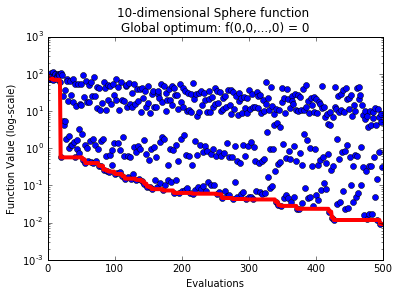

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Extract function values from the controller
# Crashed evaluations have value equal to None, so we skip those records
fvals = np.array([o.value for o in controller.fevals if o.value is not None])

f, ax = plt.subplots()
ax.semilogy(np.arange(0,maxeval), fvals, 'bo')  # Points
ax.semilogy(np.arange(0,maxeval), np.minimum.accumulate(fvals), 'r-', linewidth=4.0)  # Best value found
plt.xlabel('Evaluations')
plt.ylabel('Function Value (log-scale)')
plt.title(data.info)
plt.show()

## Written by, David Eriksson, dme65@cornell.edu
